Universidade Federal do Rio Grande do Sul (UFRGS)   
Programa de Pós-Graduação em Engenharia Civil (PPGEC)   

# PEC00144: Métodos experimentais na engenharia civil

### Trabalho final
_Adriano Rodrigues da Silva_ 

_Daniel Barbosa Mapurunga Matos_


In [3]:
#======================================================#
# 1. IMPORTING NECESSARY CLASSES AND DIMENSIONAL MATRIX#
#======================================================#

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.linalg as sc
import scipy.stats as st
from MRPy import *

DimData = pd.read_excel('Resources/DimData.xlsx')


## 1. Introdução

 Este trabalho consiste no projeto e ensaio de um modelo reduzido e está dividido como apresentado abaixo:
 

 * Projeto de modelo reduzido;
 * Construção do modelo reduzido;
 * Análise da propagação de erro;
 * Análise do sinal;
 * Instrumentação;
 * Análise do sinal;
 * Conclusão.

O modelo real consiste em um _Shear building_ de 3 pavimentos, com suas características expostas abaixo:
<img src="Resources/modelo.jpg" alt="modelo" width="480px"/>
* Dimensões dos pilares:   

  $B\times H = 0.7 \times 0.2{\rm m}$  
  
  Propriedades da seção:    
  
  $A = 0.14{\rm m}^2$ e $I = 0.000466 {\rm m}^4$ <br>
  
* Massa de um pavimento:   

  $m = 38400 {\rm kg}$    
  
*  Altura dos pilares: 

  $h =3{\rm m}$ <br>
  
* Módulo de elasticidade do concreto:

  $E_{\rm c} = 28 \times 10^{9} {\rm N/m}^2$  
  
  
* Rigidez à flexão:

  $ E_cI = 13.04 * 10^6 Nm^2 $
  
  
* Rigidez do pilar:    

  $ K = \frac{12 E_cI}{h^3} = 57.99*10^6 N/m$

O objetivo desta análise é a determinação da frequência fundamental de vibração da estrutura por meio de ensaios e verificar se estes resultados convergem para os valores calculados por meio das expressões disponíveis na literatura.



## 2. Projeto de modelo reduzido 

Para a realização do projeto de modelo reduzido, é necessário definir as 3 grandezas que formarão a nova base da matriz dimensional. Para isto, como o modelo visa a análise das frequências naturais, utiliza-se como nova base as grandezas de comprimento, aceleração e rigidez à flexão.

In [4]:
#======================================================#
# 2. MAKING DIMENSIONAL MATRIX                         #
#======================================================#
ABC    = ['L', 'a', 'EI']           
LMT    = ['L', 'M', 'T']           
base   =  DimData.loc[ABC, LMT]    
i_base =  np.linalg.inv(base)      

print(base)

    L  M  T
L   1  0  0
a   1  0 -2
EI  3  1 -2


Para definir o fator de escala da rigidez à flexão, é necessário impor as dimensões da seção transversal utilizada no modelo reduzido e o material que será utilizado. No presente estudo, será utilizada uma chapa de dimensões $ 23 \times 0.5 mm$. Abaixo está apresentado o cálculo da rigidez à flexão do modelo reduzido. 
* Módulo de elasticidade do alumínio
$$ E = 71 GPa $$
* Momento de inércia da seção
$$ I = \frac{0.023 * 0.00045^3}{12} = 1.746*10^{-13} m^4$$
* Rigidez à flexão
$$ EI = 0.012401 Nm^2 $$

As escalas adotadas no modelo são:

In [5]:
#======================================================#
# 3. DEFINING NEW SCALES                               #
#======================================================#
λ_L    =  1/30                         # Escala de comprimento do modelo reduzido
λ_a    =  1                            # Escala de acelração
λ_EI    = 0.012401/(13.04*10**6)       # Modelo construído em alumínio com seção(0.5X23mm)


Agora, é possível calcular o valor das gradezas desejadas em função da nova base dimensional.

In [6]:
#======================================================#
# 4. MAKING NEW DIMENSIONAL BASE MATRIX                #
#======================================================#
par    = ['f', 'EI', 'm']              
npar   =  len(par)                     
DimMat =  DimData.loc[par, LMT]        

print(DimMat)

    L  M  T
f   0  0 -1
EI  3  1 -2
m   0  1  0


In [7]:
scales =  np.tile([λ_L, λ_a, λ_EI],(npar,1))  

NewMat = pd.DataFrame(data    = np.matmul(DimMat, i_base),
                      index   = DimMat.index,
                      columns = ABC)
print(NewMat)

               L    a   EI
f  -5.000000e-01  0.5  0.0
EI  4.440892e-16  0.0  1.0
m  -2.000000e+00 -1.0  1.0


por fim, calculam-se as escalas:

In [8]:
#======================================================#
# 5. PRINTING NECESSARY SCALES                         #
#======================================================#
[λ_f, λ_EI, λ_m]  = np.prod(scales**NewMat, axis=1);

print('Frequência:             λ_f  = 1:{0:4.5f}'.format(1/λ_f),  '\n'
      'Rigidez à flexão:       λ_EI = 1:{0:4.0f}'.format(1/λ_EI), '\n' 
      'Massa:                  λ_m  = 1:{0:4.1f}'.format(1/λ_m))

Frequência:             λ_f  = 1:0.18257 
Rigidez à flexão:       λ_EI = 1:1051528103 
Massa:                  λ_m  = 1:1168364.6


Sendo assim, o valor da massa por pavimento será:

In [9]:
print('Massa do pavimento:     {0:5.3f}g'.format(38450*λ_m*1000))

Massa do pavimento:     32.909g


## 3. Construção do modelo reduzido
Para a construção do modelo, utilizou-se tiras de chapa de alumínio, de seção $ 23 \times 0.5 mm $ conforme especificado no projeto. O comprimento destas tiras é 35 cm, sendo 30 cm o valor calculado em projeto e os outros 5 cm para realizar o engaste na base. Para representar as massas, serão utilizadas cantoneiras de alumínio, de massa por comprimento linear igual a $1.82g/cm$. Para representar os engastes, serão utilizadas 12 presilhas( 4 em cada pavimento) de papel junto a 6 suportes de alumínio(2 por pavimento), que serão tratadas como variáveis aleatórias. A rotina a seguir calcula a média e o desvio padrão destas variáveis, assim como o tamanho da cantoneira que deverá ser utilizada no modelo.

In [10]:
#======================================================#
# 6. CALCULATING THE NECESSARY LENGHT OF THE BAR       #
#======================================================#
m_p = [2.18,2.16,2.18,2.21,2.12,2.19,2.18,2.17,2.20,2.16,2.18,2.20] #massa das presilhas em [g]
m_s = [3.61,3.59,3.62,3.60,3.60,3.59]                               #massa dos suportes em  [g]

mi_p = np.mean(m_p)
sigma_p = np.std(m_p)

mi_s = np.mean(m_s)
sigma_s = np.std(m_s)

lc = (38450*λ_m*1000 - 4*mi_p - 2*mi_s)/1.82                    # Comprimento da cantoneira

print('--------------------------------------------','\n',
      'Massa média da presilha:           {0:5.2f}g'.format(mi_p),'\n',
      'Desvio padrão da presilha:         {0:5.2f}g'.format(sigma_p),'\n',
      'Massa média do suporte:            {0:5.2f}g'.format(mi_s),'\n',
      'Desvio padrão do suporte:          {0:5.2f}g'.format(sigma_s),'\n',
      'Comprimento da cantoneira:         {0:5.2f}cm'.format(lc),'\n',
      '--------------------------------------------')


-------------------------------------------- 
 Massa média da presilha:            2.18g 
 Desvio padrão da presilha:          0.02g 
 Massa média do suporte:             3.60g 
 Desvio padrão do suporte:           0.01g 
 Comprimento da cantoneira:          9.34cm 
 --------------------------------------------


Para calcular o valor massa por pavimento, considera-se ela uma função de variáveis aleatórias, sendo expressa por:
\begin{equation}
M = 4m_p + 2m_s + 1.82l_c
\end{equation}
Em que $m_p$ e $m_s$ são, respectivamente, as massas da presilha e do suporte que serão consideradas variáveis aleatórias. Já que a função mostrada acima é linear, sendo as varáveis consideradas não correlacionadas, é possível utilizar a seguinte expressão para calcular o desvio padrão da massa do pavimento:
\begin{equation}
\sigma_M^2 = \sum_{i=1}^{n} a_i^2 \sigma_X^2
\end{equation}
Sendo $a_i$ coeficientes que multiplicam as variáveis e  $\sigma_X$ o desvio padrão de cada variável.

In [11]:
#======================================================#
# 7.ERROR PROPAGATION IN FLOOR MASS                    #
#======================================================#
mi_M = 4* mi_p + 2* mi_s+ lc*1.82
sigma_M = np.sqrt((4*sigma_p)**2+(2*sigma_s)**2)
print('--------------------------------------------','\n',
      'Massa média de um pavimento:          {0:5.2f}g'.format(mi_M),'\n',
      'Desvio Padrão:                        {0:5.2f}g'.format(sigma_M),'\n',
      '--------------------------------------------')



-------------------------------------------- 
 Massa média de um pavimento:          32.91g 
 Desvio Padrão:                         0.09g 
 --------------------------------------------


## 4. Análise da propagação de erro

Para definir o erro da frequência natural, utiliza-se uma simulação de Monte Carlo, considerando como variáveis aleatórias gaussianas o momento de inércia de área,onde admite-se um erro de 5% devido a imprecisão no corte da chapa, e a massa dos pavimentos, conforme foi calculado no terceiro tópico deste trabalho. Os valores médios e seus respectivos desvios padrões estão apresentados abaixo:

$$ I = 1.746 \pm 0.0873 *10^{-13} m^4$$
$$ M = 32.91 \pm 0.09 g$$

Devido a imprecisão na ligação dos engastes, adiciona-se um erro de 0.5 cm no comprimento das chapas de alumínio.
$$ L = 0.10 \pm 0.005 m $$

In [12]:
#======================================================#
# 8. ERROR PROPAGATION IN NATURAL FREQUENCYS           #
#======================================================#
E = 71e9
I = st.norm(1.746e-13,0.0873e-13)
M = st.norm(32.91/1000,0.09/1000)
L = st.norm(0.10,0.005)
#----------------------------------#
def autoval(E,I,L,M):
    
    K = 12*E*I/(L*L*L)
    M_K = np.array([[4*K,-2*K,0],
                   [-2*K, 4*K,-2*K],
                   [0,-2*K,2*K]])
    
    M_M = np.identity(3)*M
   
    w21,Phi1 = sc.eig(M_K,M_M)



    iw = w21.argsort()
    w21 = w21[iw]                       
    Phi1 = Phi1[:,iw]

    wr = np.real(w21)
    wk = np.sqrt(w21)
    fk = wk/(2*np.pi)
    
    return fk[0]
#------------------------------------#
n = 50000
ii = I.rvs(n)
m = M.rvs(n)
l = L.rvs(n)
fi = []
for i in range(n):
    
    f = autoval(E,ii[i],l[i],m[i])
    fi += [np.real(f)]
    
mi_f = np.mean(fi)
sigma_f = np.std(fi)
print('---------------------------------------','\n',
      'Valor médio da frequência:    {0:5.2f}hz'.format((mi_f)),'\n',
      'Valor do erro:                {0:5.2f}hz' .format(sigma_f),'\n',
      'Coeficiente de variação:      {0:5.2f}%'.format(sigma_f/np.real(mi_f)*100),'\n',
      '--------------------------------------')




--------------------------------------- 
 Valor médio da frequência:     6.77hz 
 Valor do erro:                 0.54hz 
 Coeficiente de variação:       8.02% 
 --------------------------------------


Afim de verificar o tipo de distribuição da frequência, plota-se a função de probabilidade acumulada e o histograma da resposta:

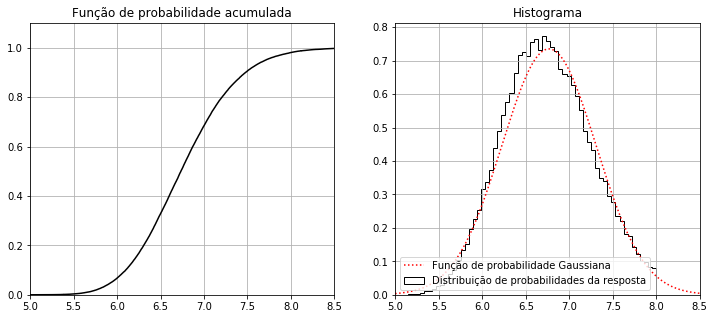

In [13]:
#======================================================#
# 9. PLOTING FREQUENCY PROBABILITY FUNCTIONS           #
#======================================================#
fx = sorted(fi)               #Colocando em ordem as frequências
fp = st.norm(mi_f,sigma_f)    # Criando uma distribuição gaussiana 
p = np.arange(0,n)/(n-1)      # Cálculo da função de probabilidade acumulada

plt.figure(1,figsize=(12,5))

plt.subplot(1,2,1)
plt.title('Função de probabilidade acumulada',size = 12)
plt.plot(fx,p,'black',drawstyle = 'steps')

plt.axis([5, 8.5, 0, 1.1])
plt.grid(True)
plt.subplot(1,2,2)

plt.title('Histograma')
plt.hist(fx,bins= 64, range =(5,8),density= True,color = 'black',histtype = 'step')
plt.plot(fx,fp.pdf(fx),'r:')
plt.xlim(5,8.5)
plt.legend(('Função de probabilidade Gaussiana','Distribuição de probabilidades da resposta'))
plt.grid(True)

A partir do exposto, é notável que a distribuição de frequências também é do tipo gaussiana.

## 5. Instrumentação
Para a realização do ensaio, utiliza-se o acelerômetro triaxial MPU6050 fixado no pavimento superior do modelo reduzido. O sinal deste acelerômetro será lido com auxílio do microcomputador Raspberry Pi 3 model B, a partir de ligações do tipo $I^2C$. A ligação entre os dois é feita a partir de fios de cobre esmaltado, afim de que estes não colaborem para o amortecimento do modelo. A Figura 2 ilustra o esquema de ligação entre o acelerômetro e o Raspberry.
<img src="Resources/rasp_acel.png" alt="esquema de ligação" width="480px"/>

O cabo vermelho corresponde ao VCC, que produz uma voltagem de 3,3 V, enquanto o preto simboliza o terra(GND). Já os cabos verde e amarelo representam, respectivamente, as ligações SDA e SCL, que serão responsáveis pela transmissão dos dados.

A Figura 3 apresenta o modelo instrumentado.
<img src="Resources/modelo_reduzido.jpg" alt="modelo reduzido" width="480px"/>


## 6. Análise do sinal
Para a determinação da frenquência fundamental de vibração, submete-se a estrutura a um deslocamento inicial, fazendo-a descrever um movimento de vibração livre amortecida. A partir da série temporal, utiliza-se o artifício do periodograma para observar qual frequência possui a maior energia armazenada, sendo esta a frequência fundamental desejada.

A partir de uma rotina em Python utilizada no Raspberry, é possível obtenção dos dados fornecidos pelo MPU6050. Com o auxílio da biblioteca ``MRPY``, é possível a realização da leitura das acelerações e da plotagem dos seus respectivos periodogramas. Este procedimento foi realizado em um Jupyter Notebook auxiliar ( ``import data``) e importado a partir da biblioteca pickle, como apresentado a seguir:

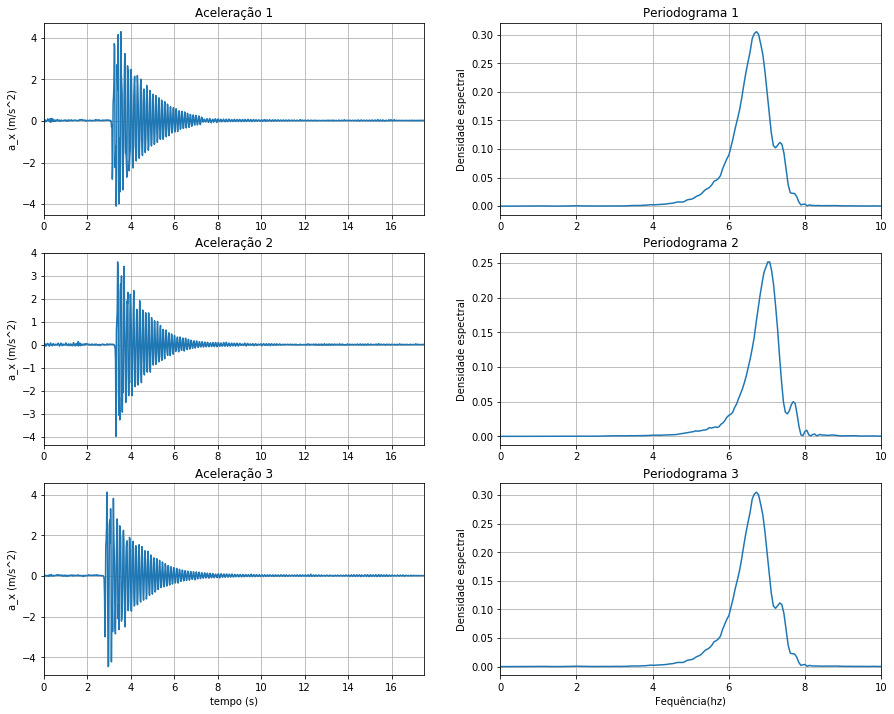

In [14]:
#======================================================#
# 10. IMPORTING AND PLOTING SIGNALS                    #
#======================================================#
import pickle as pk
with open('sample_freq.pk', 'rb') as KM:
    az, t, Saz, f,az2, t2, Saz2, f2,az3, t3, Saz3, f3 = pk.load(KM)

plt.figure(2,figsize=(15,12))
plt.subplot(3,2,1)
plt.title('Aceleração 1')
plt.plot(t, az[0],)
plt.xlim(0,17.5)
plt.ylabel('a_x (m/s^2)') 
plt.grid(True) 

plt.subplot(3,2,2)
plt.title('Periodograma 1')
plt.plot(f, Saz[0])
plt.ylabel('Densidade espectral')
plt.xlim(0,10)
plt.grid(True)

plt.subplot(3,2,3)
plt.title('Aceleração 2')
plt.plot(t2, az2[0])
plt.xlim(0,17.5)
plt.ylabel('a_x (m/s^2)') 
plt.grid(True) 

plt.subplot(3,2,4)
plt.title('Periodograma 2')
plt.plot(f2, Saz2[0])
plt.ylabel('Densidade espectral')
plt.xlim(0,10)
plt.grid(True)

plt.subplot(3,2,5)
plt.title('Aceleração 3')
plt.plot(t3, az3[0])
plt.xlim(0,17.5)
plt.xlabel('tempo (s)') 
plt.ylabel('a_x (m/s^2)') 
plt.grid(True) 

plt.subplot(3,2,6)
plt.title('Periodograma 3')
plt.plot(f3, Saz3[0])
plt.ylabel('Densidade espectral')
plt.xlim(0,10)
plt.xlabel('Fequência(hz)')
plt.grid(True)

Para encontrar o valor exato da frequência que possui maior energia em cada espectro, utiliza-se a rotina a seguir:

In [15]:
#======================================================#
# 11. PRINTING NATURAL FREQUENCYS                      #
#======================================================#
f_max1 =f[Saz[0].argmax()]
f_max2 =f2[Saz2[0].argmax()]
f_max3 =f3[Saz3[0].argmax()]

print(' As frequências naturais em cada ensaio são:','\n',
     '  Ensaio 1:               {0:5.2f}hz'.format(f_max1),'\n',
     '  Ensaio 2:               {0:5.2f}hz'.format(f_max2),'\n',
     '  Ensaio 3:               {0:5.2f}hz'.format(f_max3),'\n',)


 As frequências naturais em cada ensaio são: 
   Ensaio 1:                6.73hz 
   Ensaio 2:                7.08hz 
   Ensaio 3:                6.73hz 



## 7. Resultados e considerações finais

A partir dos valores de frequência obtidos com o uso dos espectros, é possível concluir que os valores encontrados estão dentro da margem  de erro estipulada no Capítulo 4 deste trabalho, concluindo, assim, que o modelo experimental valida a metodologia encontrada na literatura.
Para conferir se a escala de frequência adotada neste trabalho está correta, calcula-se o valor da frequência fundamental do modelo real a partir da função autoval, definidada no Capítulo 4. 

In [16]:
#======================================================#
# 12. PRINTING WORKS RESULTS                           #
#======================================================#
F_real = np.real(autoval(28e9,0.000466,3,38400))
print('-------------------------------------------------------','\n',
     'Frequência fundamental do modelo real:       {0:5.2f}hz'.format(F_real),'\n',
     'Escala de frequência:                         1:{0:5.2f}'.format(1/λ_f),'\n',
     'Frequência fundamental do modelo reduzido:   {0:5.2f}hz'.format(mi_f),'\n',
     'Frequência fundamental escalada:             {0:5.2f}hz'.format(mi_f/λ_f),'\n',
     '-------------------------------------------------------',)

------------------------------------------------------- 
 Frequência fundamental do modelo real:        1.23hz 
 Escala de frequência:                         1: 0.18 
 Frequência fundamental do modelo reduzido:    6.77hz 
 Frequência fundamental escalada:              1.24hz 
 -------------------------------------------------------


Com isso, é possível afirmar, também, que a escala obtida a partir da análise dimensional está correta, visto que o erro é desprezível.

Portanto, a partir do exposto neste trabalho, é possível concluir que a utilização do modelo reduzido como ferramenta de projeto é bastante proveitoso para problemas em que a formulação teórica  é de caráter complexo. A análise de propagação de erro, considerando como variáveis aleatórias a massa, o comprimento e a inércia possibilitou definir o erro admissível para a medição experimental, sendo fundamental para a a validação dos dados encontrados. 

A utilização do MPU6050 em conjunto com o Raspberry Pi se provou bastante eficiente para a medição da frequência fundamental de vibração, sendo possível realizar até mesmo a medição das outras frequências naturais de vibração da estrutura, apesar de possuirem uma menor energia associada. 